In [1]:
#!/usr/bin/env python
# -*- coding: UTF-8

# <p style="text-align: center;"> Analyzing Researcher-Generated Themes with Word Embedding Models in word2vec
<p style="text-align: left;">Creator: Jaren Haber, PhD Candidate<br/>Institution: Department of Sociology, University of California, Berkeley

Date created: July 20, 2018<br/>Date last modified: September 11, 2018

Description: This script uses the word embedding model (WEM) trained on the web-crawled self-descriptions of all 6,862 charter schools open in the 2015-16 school year. It uses cosine-similarity based methods in the high-dimensional vector space to assess the validity of researcher-generated themes within the texts' discursive structures. This illustrates that the "queryable neural net" of WEMs is a powerful tool for iterative interpretation of semantic structures through the lens of broader themes--whether provided by previous research or outside social domains.

## Initialize Python

In [2]:
# IMPORTING KEY PACKAGES

import gensim # for word embedding models
import numpy as np # For calculating differences in WEM results

# For cleaning, tokenizing, and stemming the text
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # approximate but effective (and common) method of normalizing words: stems words by implementing a hierarchy of linguistic rules that transform or cut off word endings

In [3]:
# FOR VISUALIZATIONS

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns # To make matplotlib prettier
sns.set(style='white')
sns.despine()

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('seaborn-white')

Populating the interactive namespace from numpy and matplotlib


In [4]:
# DEFINE FILE PATHS

charters_path = "../nowdata/traincf_2015_15_250_counts.pkl" # All text data; only charter schools

chprefix = "../Charter-school-identities/"
wordsent_path = chprefix + "data/wem_wordsent_data_train250_nostem.pkl"
phrasesent_path = chprefix + "data/wem_phrasesent_data_train250_nostem.pkl"
wem_path = chprefix + "data/wem_model_train250_nostem.txt"

# Define file paths to existing dicts
ess_path = chprefix + "dicts/ess_dict.txt"
prog_path = chprefix + "dicts/prog_dict.txt"
rit_path = chprefix + "dicts/rit_dict.txt"

# Define file paths for new dicts
ess_valid = chprefix + "dicts/ess_valid.txt"
prog_valid = chprefix + "dicts/prog_valid.txt"
rit_valid = chprefix + "dicts/rit_valid.txt"
ess_polar = chprefix + "dicts/ess_polar.txt"
prog_polar = chprefix + "dicts/prog_polar.txt"
rit_polar = chprefix + "dicts/rit_polar.txt"

## For reference: Code to train the WEM in word2vec

In [5]:
''' 
Word2Vec parameter choices explained:
- size = 300: Use hundreds of dimensions/degrees of freedom to generate accurate models from this large data set
- window = 6: Observe window of 6 context words in each direction, keeping word-word relationships moderately tight
- min_count = 3: Exclude very rare words, which occur just once or twice and typically are irrelevant proper nouns
- sg = 1: I choose a 'Skip-Gram' model over a CBOW (Continuous Bag of Words) model because skip-gram works better with larger data sets. It predicts words from contexts, rather than smoothing over context information by counting each context as a single observation
- alpha = 0.025: Initial learning rate: prevents model from over-correcting, enables finer tuning
- min_alpha = 0.001: Learning rate linearly decreases to this value over time, so learning happens more strongly at first
- iter = 5: Five passes/iterations over the dataset
- batch_words = 10000: During each pass, sample batch size of 10000 words
- workers = 1: Set to 1 to guarantee reproducibility, OR accelerate by parallelizing model training across the 44 vCPUs of the XXL Jetstream VM
- seed = 43: To increase reproducibility of model training 
- negative = 5: Draw 5 "noise words" in negative sampling in order to simplify weight tweaking
- ns_exponent = 0.75: Shape negative sampling distribution using 3/4 power, which outperforms other exponents (as popularized by original word2vec paper, Mikolov et al 2013) and slightly weights against high-frequency words (1 is exact frequencies, 0 is all words equally)

# Train the model with above parameters:
model = gensim.models.Word2Vec(words_by_sentence, 
                               size=300, 
                               window=6, 
                               min_count=3, 
                               sg=1, 
                               alpha=0.025, 
                               min_alpha=0.001,
                               iter=5, 
                               batch_words=10000, 
                               workers=1, 
                               seed=43, 
                               negative=5, 
                               ns_exponent=0.75)
                               
# For full script implementing the above (including preprocessing), see:
# https://github.com/jhaber-zz/wem4themes/blob/master/wem_training.py
'''

' \nWord2Vec parameter choices explained:\n- size = 300: Use hundreds of dimensions/degrees of freedom to generate accurate models from this large data set\n- window = 6: Observe window of 6 context words in each direction, keeping word-word relationships moderately tight\n- min_count = 3: Exclude very rare words, which occur just once or twice and typically are irrelevant proper nouns\n- sg = 1: I choose a \'Skip-Gram\' model over a CBOW (Continuous Bag of Words) model because skip-gram works better with larger data sets. It predicts words from contexts, rather than smoothing over context information by counting each context as a single observation\n- alpha = 0.025: Initial learning rate: prevents model from over-correcting, enables finer tuning\n- min_alpha = 0.001: Learning rate linearly decreases to this value over time, so learning happens more strongly at first\n- iter = 5: Five passes/iterations over the dataset\n- batch_words = 10000: During each pass, sample batch size of 1000

## Define helper functions

In [6]:
def write_list(file_path, textlist):
    """Writes textlist to file_path. Useful for recording output of parse_school()."""
    
    with open(file_path, 'w') as file_handler:
        for elem in textlist:
            file_handler.write("{}\n".format(elem))
        return    

In [7]:
def load_list(file_path):
    """Loads list into memory. Must be assigned to object."""
    
    textlist = []
    with open(file_path) as file_handler:
        line = file_handler.readline()
        while line:
            textlist.append(line)
            line = file_handler.readline()
    return textlist

In [8]:
def load_dict(custom_dict, file_path):
    """
    Loads in a dictionary from a file.
    Each word is stemmed and lower-cased in preparation for matching with word2vec.
    Adds each entry from the dict at file_path to the defined set custom_dict (the input), 
    which can also be an existing dictionary. This allows the creation of combined dictionaries!
    Multi-word dictionary elements (phrases) are transformed into a single word by
    replacing spaces with underscores, e.g. "college oriented" -> "college_oriented".
    """

    with open(file_path) as file_handler:
        line = file_handler.readline()
        while line:
            line = line.replace("\n", "") # Replace newlines at start, to avoid confusing tokenizers
            linetoks = word_tokenize(line)
            
            if len(linetoks) > 1: # For phrases (>1 word long) in dictionary
                line = [word.lower() for word in linetoks]
                line = "_".join(word for word in line)
                custom_dict.add(line.replace("_","")) # Also add element with no space between words
            else:
                line = line.lower() # For single-word dict elements, just stem it
            
            if "-" in line:
                custom_dict.add(line.replace("-","_")) # If appropriate, also add element that replaces "-" with "_"
                custom_dict.add(line.replace("-","")) # Also add element with no space between words
            
            custom_dict.add(line) # Add line after stemming dictionary entries and eliminating newlines
            line = file_handler.readline() # Look for anything else in that line, add that too
            
    return custom_dict

In [9]:
ess_dict, prog_dict, rit_dict = set(), set(), set()

ess_dict = load_dict(ess_dict, ess_path)
prog_dict = load_dict(prog_dict, prog_path)
rit_dict = load_dict(rit_dict, rit_path)

In [10]:
def make_dicts(paths_list):
    '''Create ideology dictionaries: essentialism, progressivism, and ritualism.
    Input: List of paths to all files holding dictionaries.
    Output: List of dictionaries, each of which is a list of terms.'''
    
    keydicts = [] # Initialize list holding all dicts
    
    for path in paths_list:
        thisdict = set() # Initialize variable holding terms
        thisdict = load_dict(thisdict, path) # Load from file into variable
        keydicts.append(thisdict) # Add dict to list of dicts
    
    #ess_dict, prog_dict, rit_dict, all_ideol, all_dicts = set(), set(), set(), set(), set()

    #all_ideol = load_dict(all_ideol, ess_path)
    #all_ideol = load_dict(all_ideol, prog_path) # For complete ideological list, append second ideological dict
    #all_dicts = load_dict(all_ideol, rit_path) # For complete dict list, append ritual dict terms too

    #ess_dict = load_dict(ess_dict, ess_path)
    #prog_dict = load_dict(prog_dict, prog_path)
    #rit_dict = load_dict(rit_dict, rit_path)
    
    #keydicts = [ess_dict, prog_dict, rit_dict]
    
    print("Lists of key terms (dictionaries) loaded!")
    
    return(keydicts)

In [11]:
def dict_cohere(thisdict, wem_model):
    '''Computes the average cosine similarity score of dictionary terms with each other, 
    ...one day (not yet) to be compared to the average cosine similarity score between all terms 
    in thisdict and the total model vocabulary. 
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word with all other words in the list of key terms.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dict_avg_dist = 0
    all_avg_dists = 0
    model_avg_dists = 0
    
    # Compute average cosine similarity score of each word with other dict words:
    for word in thisdict:
        word_avg_dist = (wem_model.distances(word, other_words=thisdict).sum())/len(thisdict)
        word_avg_dists += word_avg_dist
    dict_avg_dist = 1 - word_avg_dists/len(thisdict) # Find average cosine similarity score by subtracting avg. distance from 1

    # For comparison, compute average cosine similarity score of each word with ALL other words in the model vocabulary:
    #for word in thisdict:
    #    all_avg_dist = (wem_model.distances(word).sum())/len(model.vocab) # Default is to compare each word with all words
    #    all_avg_dists += all_avg_dist
    #model_avg_dist = 1 - all_avg_dists/len(model.vocab) # Find average cosine similarity score by subtracting avg. distance from 1

    #print("Average cosine similarities by word for this dictionary:       \t" + str(dict_avg_dist))
    #print("Compare to avg. cosine similarities by dict words to ALL words:\t" + str(model_avg_dist))
    
    return dict_avg_dist

## Assess validity of theoretically motivated lists of terms to corpus in word2vec 

In [12]:
# Load word2vec model:
model = gensim.models.KeyedVectors.load_word2vec_format(wem_path)

In [13]:
# Show dictionary of words in model:
print("This model contains " + str(len(model.vocab)) + " words and phrases!")
sorted(list(model.vocab))[23090:] # first 23K words mostly junk

This model contains 481295 words and phrases!


['abai',
 'abai_served',
 'abaie',
 'abailey_careeracademysb.com',
 'abair',
 'abaixo',
 'abajo',
 'abajo_para',
 'abakeman',
 'abaker_uprepschool.org',
 'aballard_nsacd.com',
 'abandon',
 'abandon_her_no_matter',
 'abandonada',
 'abandonado',
 'abandonados',
 'abandonar',
 'abandoned',
 'abandoned_building',
 'abandoned_buildings',
 'abandoned_businesses',
 'abandoned_factories',
 'abandoned_in_a_hospital',
 'abandoned_in_hospitals',
 'abandoned_or_sexually',
 'abandoning',
 'abandoning_a_book',
 'abandoning_or_endangering',
 'abandonment',
 'abandonment_and_neglect',
 'abandonment_or_neglect',
 'abandono',
 'abandono_escolar',
 'abandons',
 'abank',
 'abar',
 'abar_committee',
 'abarca',
 'abarca_una',
 'abarcar',
 'abarker_shastacoe.org',
 'abarrera_seacharter.net',
 'abarron',
 'abasilio',
 'abastecimiento_de',
 'abate',
 'abated',
 'abated_and_contained',
 'abateman',
 'abatement',
 'abatement_and_remediation',
 'abatement_project',
 'abates',
 'abating',
 'abato',
 'abaya',
 'abb

### Use WEM to find words similar to core term, 'inquiry-based':

In [14]:
# Use cosine similarity scores to find words dimensionally loaded in similar ways to given word
# Focus on core word of inquiry-based pedagogy
model.most_similar(['inquiry-based'], topn=40)

[('problem-based', 0.7188608646392822),
 ('inquiry_based', 0.7165826559066772),
 ('integrated_interdisciplinary', 0.7108476161956787),
 ('literacy-based', 0.7067997455596924),
 ('problem-based_learning', 0.705278754234314),
 ('experiential_approach', 0.6990994215011597),
 ('technology-infused', 0.6932752132415771),
 ('student-driven_exploration', 0.6918015480041504),
 ('prbl', 0.6899794340133667),
 ('showcase_of_self-driven', 0.6882768273353577),
 ('hands-on_and_minds-on', 0.687936007976532),
 ('qcss_employs', 0.6855128407478333),
 ('simulations_role-playing', 0.6846071481704712),
 ('project-centered', 0.6826268434524536),
 ('hands-on/minds-on', 0.6808892488479614),
 ('active_inquiry', 0.6793610453605652),
 ('life-based', 0.6781430244445801),
 ('problem-centered', 0.6733493804931641),
 ('long-term_in-depth', 0.6726671457290649),
 ('using_the_grr', 0.6721668243408203),
 ('hand-on', 0.6719027757644653),
 ('cognitively_demanding', 0.6715942621231079),
 ('discussion-based', 0.6715891957283

### Add more words core to this logic, hones the similar vectors even closer to the topic of interest:

In [15]:
model.most_similar(['discovery-based', 'problem-based', 'experiential_learning', 'inquiry-based', 'constructivist', 'interactive', 
                 'developmental', 'hands-on', 'socratic', 'child-centered'], topn=40)

[('hands-on_and_minds-on', 0.8754233121871948),
 ('science-driven', 0.8640522956848145),
 ('technology-infused', 0.8604103922843933),
 ('discussion-based', 0.8588686585426331),
 ('life-based', 0.8571339845657349),
 ('hands-on/minds-on', 0.8570674657821655),
 ('problem-based_learning', 0.8540046215057373),
 ('integrated_interdisciplinary', 0.8513203859329224),
 ('project-centered', 0.8512338995933533),
 ('language-rich', 0.8496240377426147),
 ('hand-on', 0.8490701913833618),
 ('experiential_approach', 0.8488446474075317),
 ('hands-on_minds-on', 0.8472220301628113),
 ('developmentally-based', 0.8443267345428467),
 ('simulations_role-playing', 0.8429721593856812),
 ('sensory-rich', 0.8423464894294739),
 ('student-driven_exploration', 0.8401151895523071),
 ('multi-modality', 0.8394434452056885),
 ('child-directed', 0.8383514285087585),
 ('andinnovative', 0.8380479216575623),
 ('exploration_and_experimentation', 0.8377096056938171),
 ('seminar-based', 0.835969090461731),
 ('movement-based',

### These seem logically related. But how well do they hang together in the vector-space?

In [17]:
# To measure how well this list of terms hang together in the corpus, 
# calculate average cosine distance between each word in list and all other words in list. 
# dict_cohere() does this:
inquiry_key = ['discovery-based', 'problem-based', 'experiential_learning', 'inquiry-based', 'constructivist', 'interactive', 
                 'developmental', 'hands-on', 'socratic', 'child-centered']

print("Average cosine similarities between inquiry-based words:\t", dict_cohere(inquiry_key, model))

Average cosine similarities between inquiry-based words:	 0.572620449066


### Now try it with 'direct instruction':

In [19]:
# Try this again using core word of logic of direct instruction
model.most_similar(['direct_instruction'], topn=50)

[('whole-group', 0.5927501916885376),
 ('skill-specific', 0.5699372887611389),
 ('multisensory', 0.5654801726341248),
 ('di_is_the_foundational', 0.5611512660980225),
 ('research-proven', 0.5532285571098328),
 ('observation_protocol', 0.5499007701873779),
 ('computer-based_software', 0.5483799576759338),
 ('includes_a_mini-lesson', 0.5479087829589844),
 ('classconnect_sessions', 0.5475315451622009),
 ('immersion_sei', 0.5472629070281982),
 ('reading/spelling', 0.5455292463302612),
 ('re-teaching_lessons', 0.5441011786460876),
 ('ddi', 0.5434328317642212),
 ('direct-instruction', 0.5422413349151611),
 ('comprehensible_input', 0.5400866866111755),
 ('trained_in_the_orton-gillingham', 0.5379807353019714),
 ('explicit_phonics', 0.5374301671981812),
 ('pull_outs', 0.5356845855712891),
 ('systematic_and_explicit', 0.5351715683937073),
 ('technology-centered', 0.5345935821533203),
 ('job-embedded', 0.5329042673110962),
 ('prek_k', 0.5328741073608398),
 ('make_private-quality', 0.5326327681541

### The similar words tie much less clearly to 'direct instruction' than did the similar words for 'inquiry-based'. 
### Try adding other words core to direct instruction model:

In [20]:
model.most_similar(['college-prep', 'direct-instruction', 'drill', 'discipline', 'data-driven', 
                 'facts', 'research-backed', 'memorization', 'rote', 
                 'no-excuses', 'core-knowledge', 'back-to-basics'], topn=40)

[('content-specific_grade-by-grade', 0.8617253303527832),
 ('concrete_manipulative', 0.8575917482376099),
 ('re-engages', 0.8552563786506653),
 ('proven_methodology', 0.8549139499664307),
 ('fun_with_phonograms', 0.8513568639755249),
 ('discussion-based_assessment', 0.8508968353271484),
 ('rigorous_skills-based', 0.850447952747345),
 ('iqwst', 0.8485308885574341),
 ('systematic_and_cumulative', 0.8463514447212219),
 ('systematic_and_explicit', 0.8463351726531982),
 ('research-based_pedagogy', 0.8462666273117065),
 ('common-core_aligned', 0.8432481288909912),
 ('rigorously_researched', 0.8425400257110596),
 ('arts-integrated_approach', 0.8423701524734497),
 ('incorporating_real-world', 0.8423523902893066),
 ('inherently_rigorous', 0.8418596386909485),
 ('outside-the-box_thinking', 0.841651439666748),
 ('content-driven', 0.8415650129318237),
 ('knowledge-rich', 0.83944171667099),
 ('inwhich', 0.8393349647521973),
 ('tcmpc', 0.8390545845031738),
 ('student-driven_exploration', 0.838780641

In [21]:
direct_key = ['college-prep', 'direct-instruction', 'drill', 'discipline', 'data-driven', 
                 'facts', 'research-backed', 'memorization', 'rote', 
                 'no-excuses', 'core-knowledge', 'back-to-basics']

print("Average cosine similarities between direct-instruction words:\t", dict_cohere(direct_key, model))

Average cosine similarities between direct-instruction words:	 0.486496716738


### This 'direct-instruction' theme doesn't hang together as well as the 'inquiry-based' theme. The similar words are all over the place.
### Which core word is most distinct from inquiry-based approach?

In [22]:
# Let's try a different approach: identify which core words from direct instruction model are least associated with inquiry
# First define the two lists again
inquiry_key = ['discovery-based', 'problem-based', 'experiential_learning', 'inquiry-based', 'constructivist', 'interactive', 
                 'developmental', 'hands-on', 'socratic', 'child-centered']
direct_key = ['college-prep', 'direct-instruction', 'drill', 'discipline', 'data-driven', 
                 'facts', 'research-backed', 'memorization', 'rote', 
                 'no-excuses', 'core-knowledge', 'back-to-basics']

# For comparison, calculate average distance of a key direct instruction word to each of key inquiry-based words.
# Divide by number of words being added up to get average distance,
# then subtract average distance from 1 to get average similarity.

print("AVERAGE SIMILARITIES FOR EACH KEY DIRECT INSTRUCTION WORD TO SET OF KEY INQUIRY WORDS:")
for word in direct_key:
    print()
    dist_matrix = 0
    dist_matrix = model.distances(word, other_words=inquiry_key)
    print('"' + word +'": ', str(1 - (dist_matrix.sum()/len(inquiry_key))) + ", stdev. = ", np.std(dist_matrix))
    print("TOP 10 SIMILAR WORDS:", [find[0] for find in model.most_similar(word, topn=10)])

AVERAGE SIMILARITIES FOR EACH KEY DIRECT INSTRUCTION WORD TO SET OF KEY INQUIRY WORDS:

"college-prep":  0.338919115067, stdev. =  0.0688112
TOP 10 SIMILAR WORDS: ['appeals_to_those_who_desire', 'content-rich_academically', 'rigorous_literacy-based', 'college-preparatory', 'technology-focused', 'four-year_sequence', 'intentionally-diverse', 'fact_that_can_not_be_ignored', 'rigorous_college-prep', 'state-chartered_public']

"direct-instruction":  0.598142528534, stdev. =  0.104955
TOP 10 SIMILAR WORDS: ['mastery-learning', 'discussion-based_assessment', 'content-driven', 'approaches_and_strategies', 'inwhich', 'learn-by-doing', 'includes_mini-lessons', 'time-on-task', 'exploration_and_experimentation', 'project-centered']

"drill":  0.194467353821, stdev. =  0.0651047
TOP 10 SIMILAR WORDS: ['place_unarmed', 'drills', 'air_rifle', 'armed_intruder', 'running_cadences', 'playground_while_repeating', 'aiphs_fire', 'armed_rifle', 'footwork', 'dremel']

"discipline":  0.289790821075, stdev. =

### 'Drill' connotes something other than direct instruction--military school/ROTC!
### Two other core terms stand out: 'facts' (avg. similarity to inquiry list = 0.23) and 'discipline' (0.29). Let's explore each:

In [23]:
model.most_similar(['facts'], topn=40)

[('recalling_the_basic', 0.5797891616821289),
 ('continuously_studying', 0.566006600856781),
 ('persevere_in_their_pursuit', 0.565056324005127),
 ('subtraction_facts', 0.5630351305007935),
 ('memorization_of_basic', 0.5610184669494629),
 ('multiplication_facts', 0.5583810806274414),
 ('recall_basic', 0.5577952861785889),
 ('basic_multiplication', 0.5571771860122681),
 ('reporting_of_erroneous', 0.5562953352928162),
 ('hobbies_and_fun', 0.5529751777648926),
 ('details_to_accentuate', 0.5502032041549683),
 ('topic_with_well-chosen', 0.5498110055923462),
 ('must_be_memorized', 0.5484017133712769),
 ('palcs_fast', 0.5473330020904541),
 ('automatic_fluency', 0.5417510867118835),
 ('categorize_and_organize', 0.5411500930786133),
 ('pertinent_descriptions', 0.5381637811660767),
 ('memorization_of_isolated', 0.5370516180992126),
 ('scoot_math', 0.5362907648086548),
 ('workbook_p.', 0.5353248119354248),
 ('fact_dash', 0.5345492959022522),
 ('requiring_literal', 0.5333884954452515),
 ('understan

In [24]:
model.most_similar(['facts', 'recalling_the_basic', 'continuously_studying', 'memorization_of_basic', 'recall_basic', 
                    'categorize_and_organize',
                    ], topn=40)

[('scoot_math', 0.8782311081886292),
 ('hobbies_and_fun', 0.8746008276939392),
 ('palcs_fast', 0.8582767248153687),
 ('persevere_in_their_pursuit', 0.853203296661377),
 ('endeavor_fast', 0.8495290279388428),
 ('carrying_and_borrowing', 0.8494324088096619),
 ('conveys_ideas', 0.8451281785964966),
 ('reporting_of_erroneous', 0.8422176837921143),
 ('50states.com', 0.8392870426177979),
 ('logical_interpretation', 0.8392834663391113),
 ('automatic_fluency', 0.8382155895233154),
 ('era_fast', 0.833683967590332),
 ('three_addends', 0.8302927613258362),
 ('fruit_splat', 0.8302254676818848),
 ('supplementary_complementary', 0.8297640681266785),
 ('fact_dash', 0.828467845916748),
 ('isolated_unknown', 0.8247178792953491),
 ('regurgitation', 0.8230201601982117),
 ('workbook_page', 0.8216412663459778),
 ('workbook_p.', 0.8200268149375916),
 ('merely_the_acquisition', 0.8193114995956421),
 ('solving_inequalities', 0.8192421197891235),
 ('sentence_involving', 0.8189988136291504),
 ('inclass', 0.8174

In [25]:
dict_cohere(['facts', 'recalling_the_basic', 'continuously_studying', 'memorization_of_basic', 'recall_basic', 
                    'categorize_and_organize',
                   ], model)

0.73384506172604036

### The 'facts' theme holds together well, but relates mostly to math and worksheets.
### How about the 'discipline' theme?

In [26]:
model.most_similar(['discipline'], topn=40)

[('strategy_to_reduce', 0.6351543664932251),
 ('affirmation_of_prior', 0.6228364706039429),
 ('gdqd', 0.6096998453140259),
 ('\uf0b7_adhering', 0.6071077585220337),
 ('\uf0b7_enforce', 0.6064615249633789),
 ('progressive_disciplinary', 0.6056464910507202),
 ('violations_and_to_appropriately', 0.6036338806152344),
 ('rigor_are_not_the_enemy', 0.6014862656593323),
 ('decorum_respect', 0.6013566851615906),
 ('try_to_deter', 0.6013294458389282),
 ('recommendation_for_lesser', 0.5982348918914795),
 ('total_shock', 0.5963038206100464),
 ('supporting_and_adhering', 0.5937507152557373),
 ('discipline_issues', 0.5923269391059875),
 ('off-campus_misconduct', 0.5918329954147339),
 ('approximately_allegations', 0.5913819670677185),
 ('severe_to_deter', 0.5910464525222778),
 ('considerate_behavior', 0.5899034142494202),
 ('18a:37-1', 0.5891992449760437),
 ('relational_approach', 0.5873907804489136),
 ('brings_out_consciously', 0.5872412919998169),
 ('§121a.582', 0.5862783789634705),
 ('promoting_ex

In [27]:
# The 'discipline' theme reflects behavioral codes and procedures:
model.most_similar(['discipline', 'strategy_to_reduce', 'progressive_disciplinary', 'try_to_deter', 'expellable', 
                   'severe_to_deter', 'condones_or_tolerates', 'consequences_will_be_sufficiently', 'behavior/discipline',
                   ], topn=40)

[('gdqd', 0.891257643699646),
 ('violations_and_to_appropriately', 0.8906736373901367),
 ('nrs_inclusive', 0.8902461528778076),
 ('§121a.582', 0.8792023658752441),
 ('recommendation_for_lesser', 0.878533661365509),
 ('drug-related', 0.8736090660095215),
 ('disciplinaryaction', 0.8725650310516357),
 ('condones', 0.8714126348495483),
 ('18a:37-1', 0.8705106973648071),
 ('disci', 0.870451807975769),
 ('offenses_resulting', 0.8700428009033203),
 ('respond_remediate', 0.8690510988235474),
 ('aversive_techniques', 0.868960976600647),
 ('suf\x00iciently', 0.8686482906341553),
 ('\x04_willful', 0.8682864904403687),
 ('violate_this_prohibition', 0.8680892586708069),
 ('severe_or_repeated', 0.8678847551345825),
 ('deter_violations', 0.8661466836929321),
 ('victim_that_resulted', 0.8661466836929321),
 ('§121a.58', 0.866075336933136),
 ('consequences_for_the_perpetrator', 0.8637219667434692),
 ('enforced_consistently', 0.8608658909797668),
 ('chronic_irresolvable', 0.8598017692565918),
 ('120a.34'

In [28]:
dict_cohere(['discipline', 'strategy_to_reduce', 'progressive_disciplinary', 'try_to_deter', 'expellable', 
                   'severe_to_deter', 'condones_or_tolerates', 'consequences_will_be_sufficiently', 'behavior/discipline',
                   ], model)

0.74399043306892298

### The coherent 'discipline' theme reflects behavioral codes and procedures. 
## Neither the 'discipline' nor 'facts' theme really directly gets at the logic of direct instruction. Even very inquiry-focused schools may have clear disciplinary codes and math worksheets.

## Visually contrast 'college-prep' vs. 'inquiry-based'

In [29]:
# Let's work with the binary between direct instruction and inquiry-based
# first let's find the 100 words closest to each approach
inq_words = model.most_similar('inquiry-based', topn=100)
inq_words = [word for word, similarity in inq_words]

print(inq_words[:20])

['problem-based', 'inquiry_based', 'integrated_interdisciplinary', 'literacy-based', 'problem-based_learning', 'experiential_approach', 'technology-infused', 'student-driven_exploration', 'prbl', 'showcase_of_self-driven', 'hands-on_and_minds-on', 'qcss_employs', 'simulations_role-playing', 'project-centered', 'hands-on/minds-on', 'active_inquiry', 'life-based', 'problem-centered', 'long-term_in-depth', 'using_the_grr']


In [30]:
# now let's get the 100 most similar words for direct instruction
direct_words = model.most_similar('college-prep', topn=100)
direct_words = [word for word, similarity in direct_words]

print(direct_words[:20])

['appeals_to_those_who_desire', 'content-rich_academically', 'rigorous_literacy-based', 'college-preparatory', 'technology-focused', 'four-year_sequence', 'intentionally-diverse', 'fact_that_can_not_be_ignored', 'rigorous_college-prep', 'state-chartered_public', 'rigorous_content-rich', 'providing_a_well-rounded', 'dchs_offers', 'pre-advance', 'character-based', 'committed_to_delivering', 'culturally-rich', 'strategically_designed', 'diploma-granting', 'classically_based']


In [31]:
# construct a combined dictionary
pedgy_words = direct_words + inq_words

In [32]:
# prepare to visualize this binary with word2vec by finding each word's similarity to focal word
x = [model.similarity('inquiry-based', word) for word in pedgy_words]
y = [model.similarity('college-prep', word) for word in pedgy_words]

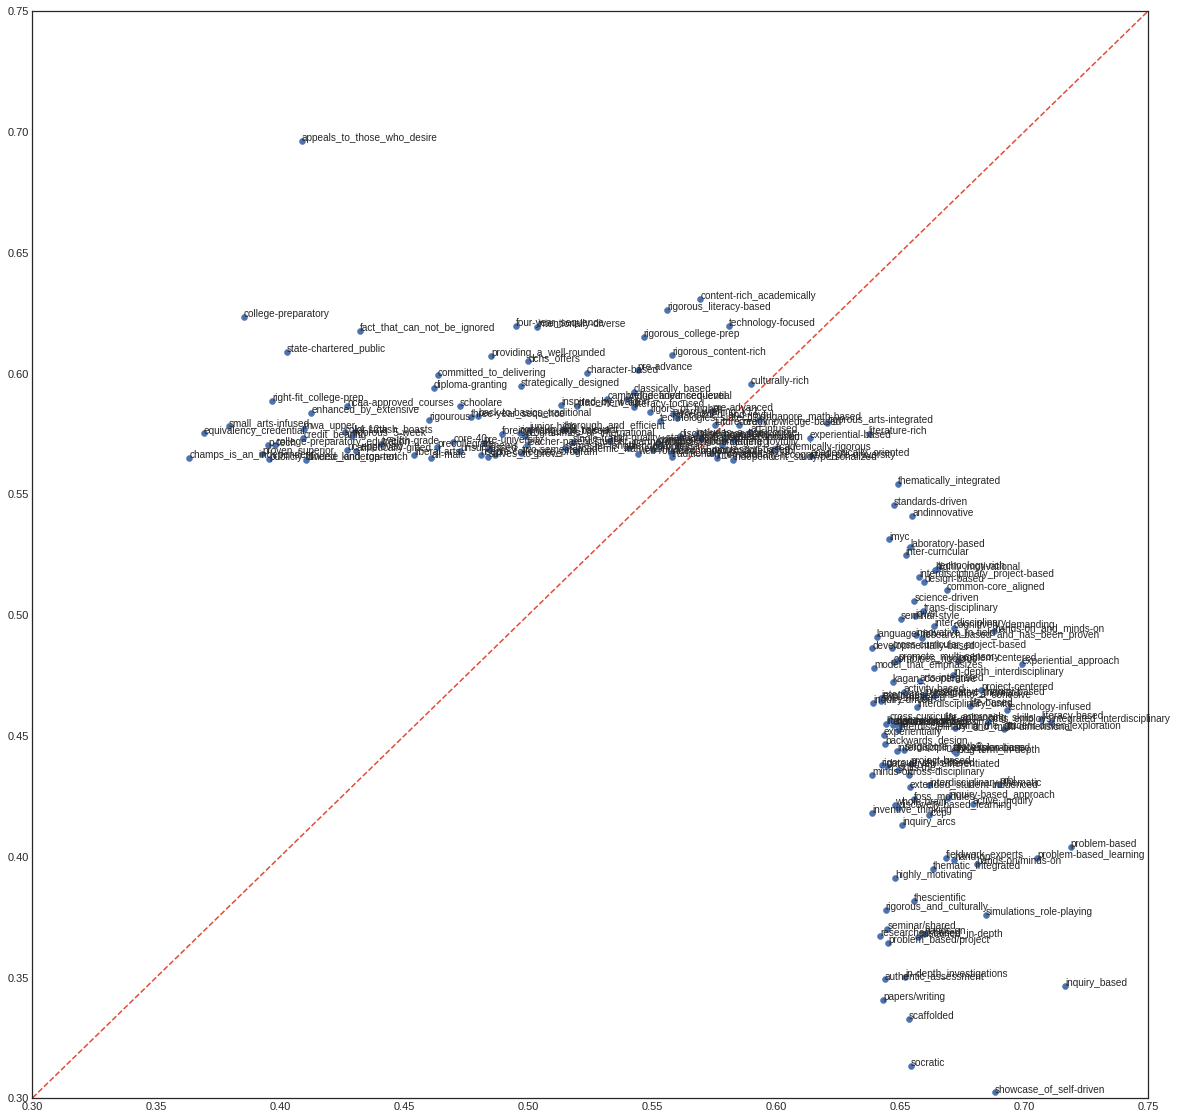

In [33]:
# visualize binary
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(pedgy_words)):
    ax.annotate(pedgy_words[i], (x[i], y[i]))
ax.set_xlim(0.3, .75)
ax.set_ylim(0.3, .75)
plt.plot([0, 1], [0, 1], linestyle='--');

### Binary of direct-instruction (top) and inquiry-based (right) word vectors